## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import re
import gc
import copy

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import nltk.data

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm_notebook as tqdm
from transformers import RobertaTokenizer
import transformers

from text_data import TextDataset5 as TextDataset
from roberta import CustomRoberta
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from create_features import get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np, optimize_rounding_params, get_cvs, spearmanr
from inference import infer
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv')
train = pd.read_csv(f'{path}train.csv')

In [3]:
%%time
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
seg_ids_train, ids_train = {}, {}
seg_ids_test, ids_test = {}, {}
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    for text, cols in [('question', ['question_title', 'question_body']), 
                       ('answer', ['question_title', 'answer'])]:
        ids, seg_ids, sent_ids = [], [], []
        for x1, x2 in tqdm(df[cols].values):
            encoded_inputs = tokenizer.encode_plus(
                x1, x2, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True, 
                return_token_type_ids=True
            )
            ids.append(encoded_inputs['input_ids'])
            seg_ids.append(encoded_inputs['token_type_ids'])
        if mode == 'train': 
            ids_train[text] = np.array(ids)
            seg_ids_train[text] = np.array(seg_ids)
        else: 
            ids_test[text] = np.array(ids)
            seg_ids_test[text] = np.array(seg_ids)


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



CPU times: user 14.2 s, sys: 115 ms, total: 14.3 s
Wall time: 15.2 s


In [4]:
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [5]:
cat_features_train = train_category.reshape(-1, 1)
cat_features_test = test_category.reshape(-1, 1)
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [6]:
for col in TARGETS:
    train[col] = train[col].rank(method="average")
train[TARGETS] = MinMaxScaler().fit_transform(train[TARGETS])
y = train[TARGETS].values.astype(np.float32)
ix = np.where(train.groupby("question_body")["host"].transform("count") == 1)[0]

In [7]:
num_workers = 10
bs = 2

In [8]:
bs_test = 2
test_loader = DataLoader(
    TextDataset(cat_features_test, ids_test['question'], ids_test['answer'], 
                seg_ids_test['question'], seg_ids_test['answer'], test.index),
    batch_size=bs_test, shuffle=False, num_workers=num_workers, drop_last=False
)

## Training model

In [9]:
lr = 0.001
loss_fn = nn.BCEWithLogitsLoss()
device = 'cuda'
n_epochs = 4
grad_accum = 4
weight_decay = 0.01
model_name = 'siamese_roberta_1'
checkpoint_dir = 'checkpoints/'
early_stopping = None
n_folds = 10

In [10]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters

def get_optimizer(model, lr, weight_decay):
    return transformers.AdamW(
        get_optimizer_param_groups(model.head, lr, weight_decay)
        + get_optimizer_param_groups(model.roberta, lr / 100, weight_decay)
    )

Fold 1 started at Thu Jan 30 00:17:27 2020


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


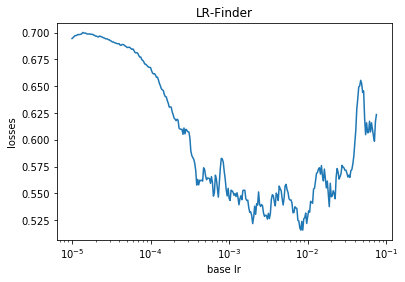

epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.5216 - spearmanr 0.19867
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.49221 - spearmanr 0.35822


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


best model: epoch 0 - 0.35822
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.46558 - spearmanr 0.36622
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45692 - spearmanr 0.41023
best model: epoch 1 - 0.41023
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.44391 - spearmanr 0.42748
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.44908 - spearmanr 0.42214
best model: epoch 2 - 0.42214
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.42621 - spearmanr 0.47502
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.44931 - spearmanr 0.42462
best model: epoch 3 - 0.42462
TRAINING END: Best score achieved on epoch 3 - 0.42462
Starting inference for model: checkpoints/siamese_roberta_1_fold_1_best.pth



Averaged Val. score: 0.42462295727739735
Starting inference for model: checkpoints/siamese_roberta_1_fold_1_best.pth



Fold 2 started at Thu Jan 30 00:58:11 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.52102 - spearmanr 0.19564
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.48509 - spearmanr 0.3526
best model: epoch 0 - 0.3526
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.46595 - spearmanr 0.36352
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45881 - spearmanr 0.40923
best model: epoch 1 - 0.40923
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.44358 - spearmanr 0.42652
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45312 - spearmanr 0.42352
best model: epoch 2 - 0.42352
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.42621 - spearmanr 0.47287
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45182 - spearmanr 0.42681
best model: epoch 3 - 0.42681
TRAINING END: Best score achieved on epoch 3 - 0.42681
Starting inference for model: checkpoints/siamese_roberta_1_fold_2_best.pth



Averaged Val. score: 0.4268135273697342
Starting inference for model: checkpoints/siamese_roberta_1_fold_2_best.pth



Fold 3 started at Thu Jan 30 01:37:31 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.5227 - spearmanr 0.18566
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.48792 - spearmanr 0.31722
best model: epoch 0 - 0.31722
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.46596 - spearmanr 0.36484
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.4598 - spearmanr 0.39509
best model: epoch 1 - 0.39509
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.4435 - spearmanr 0.42675
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45565 - spearmanr 0.41138
best model: epoch 2 - 0.41138
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.42583 - spearmanr 0.47499
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45457 - spearmanr 0.4105
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.41138
Starting inference for model: checkpoints/siamese_roberta_1_fold_3_best.pth



Averaged Val. score: 0.41137986811814786
Starting inference for model: checkpoints/siamese_roberta_1_fold_3_best.pth



Fold 4 started at Thu Jan 30 02:16:47 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.52018 - spearmanr 0.20105
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.4845 - spearmanr 0.32267
best model: epoch 0 - 0.32267
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.4649 - spearmanr 0.36873
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46221 - spearmanr 0.37706
best model: epoch 1 - 0.37706
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.44357 - spearmanr 0.42758
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45562 - spearmanr 0.39779
best model: epoch 2 - 0.39779
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.42537 - spearmanr 0.47681
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45539 - spearmanr 0.39791
best model: epoch 3 - 0.39791
TRAINING END: Best score achieved on epoch 3 - 0.39791
Starting inference for model: checkpoints/siamese_roberta_1_fold_4_best.pth



Averaged Val. score: 0.39791165207009643
Starting inference for model: checkpoints/siamese_roberta_1_fold_4_best.pth



Fold 5 started at Thu Jan 30 02:56:05 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.52209 - spearmanr 0.19578
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47939 - spearmanr 0.33523
best model: epoch 0 - 0.33523
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.46609 - spearmanr 0.36679
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45622 - spearmanr 0.38985
best model: epoch 1 - 0.38985
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.44353 - spearmanr 0.43022
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.44964 - spearmanr 0.40953
best model: epoch 2 - 0.40953
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.42527 - spearmanr 0.47904
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.44994 - spearmanr 0.41025
best model: epoch 3 - 0.41025
TRAINING END: Best score achieved on epoch 3 - 0.41025
Starting inference for model: checkpoints/siamese_roberta_1_fold_5_best.pth



Averaged Val. score: 0.41025407382024404
Starting inference for model: checkpoints/siamese_roberta_1_fold_5_best.pth



Fold 6 started at Thu Jan 30 03:35:23 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.52184 - spearmanr 0.19878
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47103 - spearmanr 0.35597
best model: epoch 0 - 0.35597
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.46316 - spearmanr 0.37383
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.44926 - spearmanr 0.39288
best model: epoch 1 - 0.39288
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.44179 - spearmanr 0.43482
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.44569 - spearmanr 0.40062
best model: epoch 2 - 0.40062
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.42378 - spearmanr 0.48182
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.446 - spearmanr 0.4032
best model: epoch 3 - 0.4032
TRAINING END: Best score achieved on epoch 3 - 0.40320
Starting inference for model: checkpoints/siamese_roberta_1_fold_6_best.pth



Averaged Val. score: 0.40320168038000365
Starting inference for model: checkpoints/siamese_roberta_1_fold_6_best.pth



Fold 7 started at Thu Jan 30 04:14:43 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.5221 - spearmanr 0.18898
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.48369 - spearmanr 0.35019
best model: epoch 0 - 0.35019
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.46553 - spearmanr 0.36555
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45957 - spearmanr 0.39686
best model: epoch 1 - 0.39686
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.44361 - spearmanr 0.42831
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45229 - spearmanr 0.41741
best model: epoch 2 - 0.41741
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.42585 - spearmanr 0.47403
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45293 - spearmanr 0.41868
best model: epoch 3 - 0.41868
TRAINING END: Best score achieved on epoch 3 - 0.41868
Starting inference for model: checkpoints/siamese_roberta_1_fold_7_best.pth



Averaged Val. score: 0.4186791696491003
Starting inference for model: checkpoints/siamese_roberta_1_fold_7_best.pth



Fold 8 started at Thu Jan 30 04:54:02 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.52195 - spearmanr 0.19104
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.48695 - spearmanr 0.35046
best model: epoch 0 - 0.35046
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.46405 - spearmanr 0.36637
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46545 - spearmanr 0.41073
best model: epoch 1 - 0.41073
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.44266 - spearmanr 0.42695
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45637 - spearmanr 0.4244
best model: epoch 2 - 0.4244
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.42466 - spearmanr 0.47584
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45663 - spearmanr 0.42591
best model: epoch 3 - 0.42591
TRAINING END: Best score achieved on epoch 3 - 0.42591
Starting inference for model: checkpoints/siamese_roberta_1_fold_8_best.pth



Averaged Val. score: 0.4259084245163255
Starting inference for model: checkpoints/siamese_roberta_1_fold_8_best.pth



Fold 9 started at Thu Jan 30 05:33:22 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.52087 - spearmanr 0.19907
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.48767 - spearmanr 0.32755
best model: epoch 0 - 0.32755
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.46618 - spearmanr 0.36584
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.4582 - spearmanr 0.39525
best model: epoch 1 - 0.39525
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.44368 - spearmanr 0.42709
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45202 - spearmanr 0.40618
best model: epoch 2 - 0.40618
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.42662 - spearmanr 0.47334
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.44994 - spearmanr 0.4122
best model: epoch 3 - 0.4122
TRAINING END: Best score achieved on epoch 3 - 0.41220
Starting inference for model: checkpoints/siamese_roberta_1_fold_9_best.pth



Averaged Val. score: 0.4122011096650848
Starting inference for model: checkpoints/siamese_roberta_1_fold_9_best.pth



Fold 10 started at Thu Jan 30 06:12:42 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.52237 - spearmanr 0.19287
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47798 - spearmanr 0.35423
best model: epoch 0 - 0.35423
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.46599 - spearmanr 0.36613
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45298 - spearmanr 0.40184
best model: epoch 1 - 0.40184
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.44431 - spearmanr 0.42707
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.44381 - spearmanr 0.41746
best model: epoch 2 - 0.41746
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.42583 - spearmanr 0.47734
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.44278 - spearmanr 0.41928
best model: epoch 3 - 0.41928
TRAINING END: Best score achieved on epoch 3 - 0.41928
Starting inference for model: checkpoints/siamese_roberta_1_fold_10_best.pth



Averaged Val. score: 0.41927951273904446
Starting inference for model: checkpoints/siamese_roberta_1_fold_10_best.pth



OOF score: 0.4150428004110002


In [11]:
init_seed()
folds = GroupKFold(n_splits=n_folds).split(X=train['question_body'], groups=train['question_body'])
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], train_index, targets=y), 
        batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=False
    )
    valid_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], valid_index, targets=y), 
        batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False
    )
    model = CustomRoberta(256, cat_features_train.shape[1])
    
    if fold_id == 0:
#         print(model)
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-5, 
                             end_lr=1, device=device, grad_accum=grad_accum, divergence_factor=5)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=scheduler, 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=True
    )
    if (fold_id + 1) > 0: learner.train()
        
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    print(f'Averaged Val. score: {spearmanr_np(oofs[valid_index], y[valid_index])}')
    
    test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
    preds += test_preds / n_folds
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')

In [12]:
opt_ds, opt_indices = optimize_rounding_params(oofs, y)

2 4 0.4882820916491322
5 4 0.4607674888189482
9 64 0.13311648150120614
11 8 0.7482469426121363
12 4 0.55478740336244
13 4 0.2769004268626699
14 4 0.6445585062178463
15 4 0.5809674116303465
19 64 0.17432292230246713


In [13]:
np.array(opt_ds), np.array(opt_indices)

(array([ 4,  4, 64,  8,  4,  4,  4,  4, 64]),
 array([ 2,  5,  9, 11, 12, 13, 14, 15, 19]))

In [14]:
oofs_alt = oofs.copy()
train["eng"] = train["url"].apply(lambda x: x.startswith("http://english.") or x.startswith("http://ell."))
oofs_alt[np.where((~train["eng"]).values)[0], 19] = 0

In [15]:
get_cvs(oofs, y, ix)

,SpearmanR
CV,0.415043
CV unique rows,0.381389
CV ignoring hard targets,0.439469
CV unique rows ignoring hard targets,0.403282
CV w rounding,0.447054
CV unique rows w rounding,0.426674
CV ignoring hard targets w rounding,0.468007
CV unique rows ignoring hard targets w rounding,0.442758


In [16]:
get_cvs(oofs_alt, y, ix)

,SpearmanR
CV,0.419121
CV unique rows,0.385482
CV ignoring hard targets,0.439469
CV unique rows ignoring hard targets,0.403282
CV w rounding,0.447736
CV unique rows w rounding,0.427072
CV ignoring hard targets w rounding,0.468007
CV unique rows ignoring hard targets w rounding,0.442758


In [17]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [18]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.837862,0.564325,0.467797,0.389515,0.349571,0.242406,0.712970,0.764764,0.751528,0.005653,0.853334,0.800661,0.038299,0.595146,0.005894,0.004910,0.048158,0.129158,0.684102,0.000373,0.854358,0.689503,0.264898,0.814842,0.803671,0.449447,0.021823,0.047978,0.776744,0.718936
1,46,0.504764,0.282290,0.006543,0.659833,0.682152,0.878660,0.385003,0.259392,0.222859,0.005332,0.479820,0.597159,0.004090,0.001060,0.001265,0.008963,0.848761,0.344095,0.163118,0.000138,0.344586,0.733673,0.483557,0.826285,0.876378,0.501934,0.864365,0.304710,0.177458,0.642545
2,70,0.710446,0.593587,0.040533,0.717840,0.844141,0.883083,0.516541,0.402623,0.345290,0.006971,0.233591,0.819223,0.036832,0.171034,0.004504,0.012634,0.122550,0.135413,0.598902,0.000956,0.756700,0.637449,0.291742,0.756468,0.704634,0.431839,0.052446,0.089403,0.754520,0.624807
3,132,0.587196,0.289725,0.008038,0.583270,0.655550,0.819265,0.412161,0.266557,0.205095,0.012840,0.575643,0.060635,0.002931,0.002643,0.000717,0.009375,0.809997,0.305840,0.647285,0.000091,0.457972,0.721294,0.551513,0.836005,0.866279,0.568241,0.832738,0.312460,0.579436,0.608520
4,200,0.806361,0.313797,0.065269,0.749619,0.746449,0.824926,0.649215,0.712363,0.362328,0.010511,0.394576,0.786170,0.022895,0.043087,0.004080,0.018361,0.169142,0.202778,0.581671,0.001597,0.556617,0.754306,0.526873,0.866688,0.859068,0.611050,0.265993,0.261321,0.659596,0.675571


In [19]:
pd.DataFrame(oofs, columns=TARGETS).to_csv(f'oofs/{model_name}_oofs.csv')

In [20]:
pd.DataFrame(oofs, columns=TARGETS)

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0.865206,0.633663,0.290000,0.663035,0.499526,0.314556,0.657218,0.548898,0.092673,0.002304,0.728528,0.027207,0.532745,0.040713,0.007380,0.233992,0.146011,0.053212,0.496233,0.000725,0.824949,0.909926,0.570146,0.966331,0.951258,0.782928,0.086115,0.051059,0.881580,0.820157
1,0.887193,0.827489,0.056630,0.490016,0.934940,0.545904,0.636214,0.812597,0.429503,0.001545,0.296529,0.055716,0.728409,0.003685,0.894830,0.026711,0.027803,0.037958,0.299818,0.002999,0.862911,0.417114,0.244352,0.673472,0.785933,0.237227,0.017624,0.021961,0.255763,0.845622
2,0.680218,0.429726,0.012984,0.637432,0.784817,0.792252,0.482370,0.335656,0.115763,0.001902,0.398970,0.113412,0.009172,0.002872,0.002215,0.208180,0.744078,0.322607,0.166028,0.000271,0.714563,0.867469,0.570660,0.923284,0.917704,0.689871,0.770341,0.302265,0.461869,0.791034
3,0.862373,0.799969,0.048016,0.850867,0.927226,0.914958,0.574576,0.619505,0.336369,0.000728,0.093996,0.861314,0.028762,0.010805,0.226266,0.082853,0.014404,0.078494,0.490469,0.004869,0.806162,0.739182,0.689056,0.787425,0.813950,0.673769,0.016126,0.072369,0.832579,0.630657
4,0.834928,0.866113,0.005789,0.668411,0.811715,0.892840,0.537634,0.453724,0.151544,0.000337,0.318095,0.403327,0.002215,0.000613,0.000816,0.004132,0.855066,0.356896,0.090442,0.000026,0.876579,0.687074,0.380957,0.796682,0.818743,0.519478,0.847058,0.245337,0.042227,0.610518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,0.823873,0.539324,0.195793,0.800497,0.675395,0.588561,0.590267,0.570256,0.523299,0.006930,0.570136,0.897726,0.081988,0.293094,0.030623,0.118892,0.075798,0.113999,0.522984,0.004511,0.758355,0.861882,0.642604,0.925207,0.917307,0.667828,0.162304,0.148171,0.811375,0.768139
6075,0.847260,0.442380,0.134753,0.487280,0.565175,0.407715,0.667030,0.643411,0.140473,0.007407,0.700799,0.101852,0.033230,0.008762,0.002466,0.030259,0.768256,0.422559,0.177977,0.000637,0.755957,0.868440,0.544180,0.910477,0.934193,0.646157,0.845238,0.385360,0.277369,0.870422
6076,0.627520,0.400829,0.008111,0.639009,0.735069,0.857550,0.401908,0.309743,0.226465,0.004898,0.404706,0.561464,0.004878,0.003355,0.001409,0.010796,0.820426,0.385823,0.215286,0.000328,0.563756,0.605813,0.368876,0.769881,0.759639,0.383049,0.724406,0.255564,0.484284,0.473877
6077,0.866384,0.698346,0.624069,0.561536,0.384778,0.259771,0.615433,0.789314,0.435145,0.002171,0.854287,0.791850,0.130695,0.038727,0.022680,0.018043,0.014096,0.101185,0.690914,0.000674,0.887577,0.789331,0.644397,0.872451,0.903664,0.652181,0.009388,0.093422,0.876830,0.816504


In [21]:
rs = pd.Series({col: spearmanr(oofs[:,i], y[:,i])[0] for i, col in enumerate(TARGETS)})
rs

question_asker_intent_understanding      0.386775
question_body_critical                   0.611962
question_conversational                  0.411792
question_expect_short_answer             0.310464
question_fact_seeking                    0.366345
question_has_commonly_accepted_answer    0.431670
question_interestingness_others          0.357865
question_interestingness_self            0.507886
question_multi_intent                    0.571744
question_not_really_a_question           0.082535
question_opinion_seeking                 0.483671
question_type_choice                     0.738248
question_type_compare                    0.365404
question_type_consequence                0.186507
question_type_definition                 0.364622
question_type_entity                     0.457195
question_type_instructions               0.781756
question_type_procedure                  0.376143
question_type_reason_explanation         0.675079
question_type_spelling                   0.063630


In [22]:
rs_df = pd.DataFrame(np.vstack([rs.values.flatten(), train[TARGETS].nunique()]).T, 
                     columns=['SpearmanCorr', 'NUnique'], index=rs.index)
rs_df.sort_values('SpearmanCorr', ascending=True)

,SpearmanCorr,NUnique
question_type_spelling,0.063630,3.0
question_not_really_a_question,0.082535,5.0
answer_plausible,0.164497,9.0
answer_relevance,0.183612,9.0
question_type_consequence,0.186507,5.0
answer_well_written,0.212028,9.0
answer_helpful,0.259183,9.0
question_expect_short_answer,0.310464,5.0
answer_type_procedure,0.319060,5.0
question_interestingness_others,0.357865,9.0


In [23]:
sorted_targets = rs_df.sort_values('SpearmanCorr', ascending=True).index
worst_five_targets = sorted_targets[:5]
worst_five_targets

Index(['question_type_spelling', 'question_not_really_a_question',
       'answer_plausible', 'answer_relevance', 'question_type_consequence'],
      dtype='object')

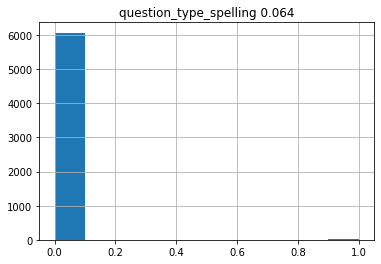

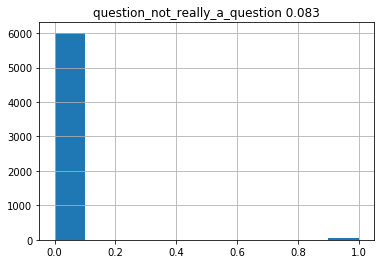

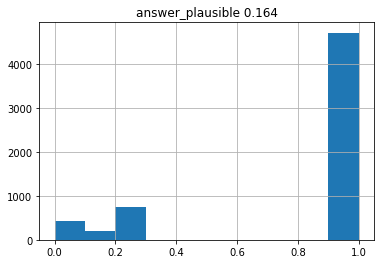

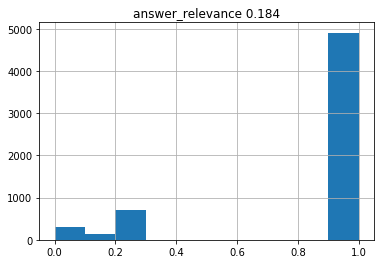

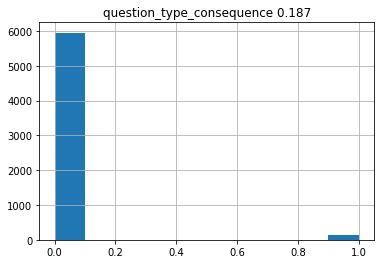

In [24]:
for col in worst_five_targets:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


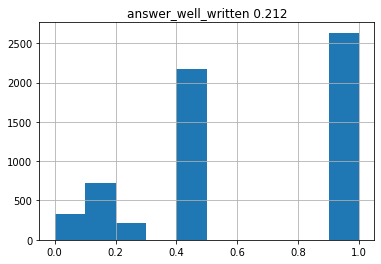

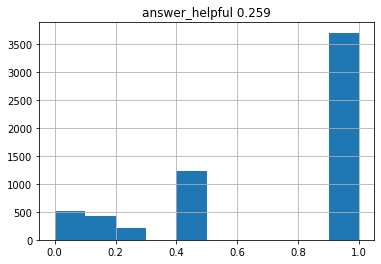

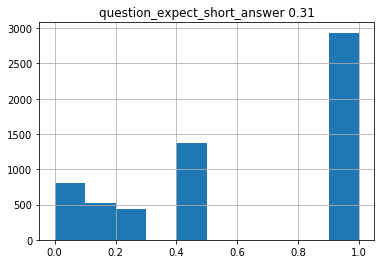

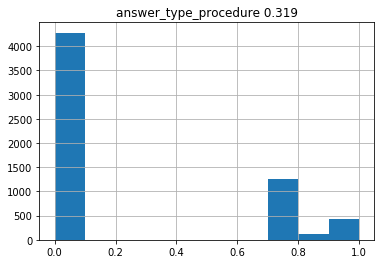

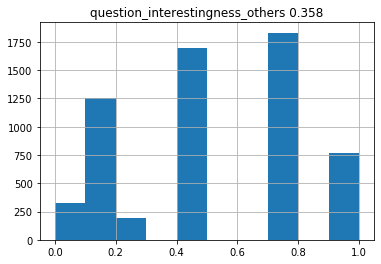

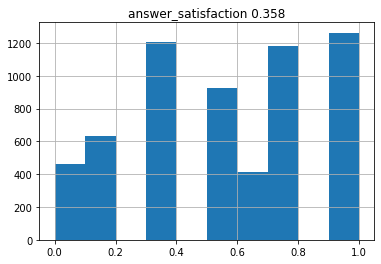

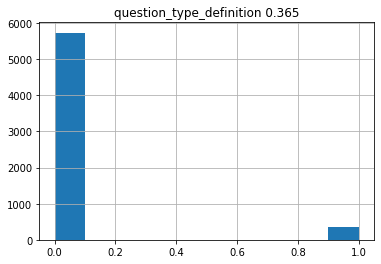

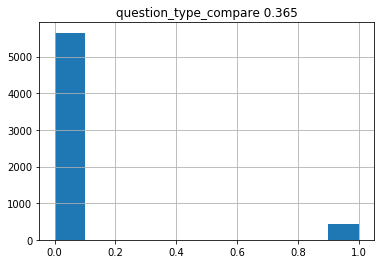

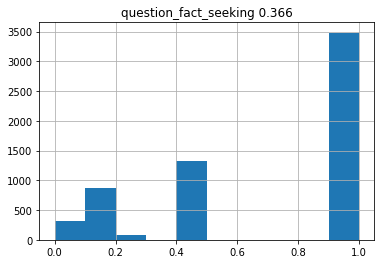

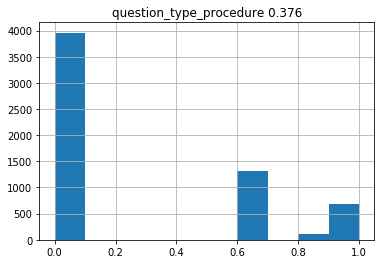

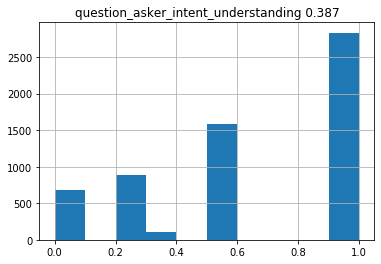

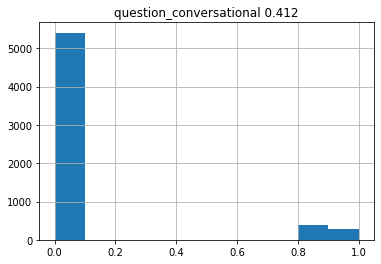

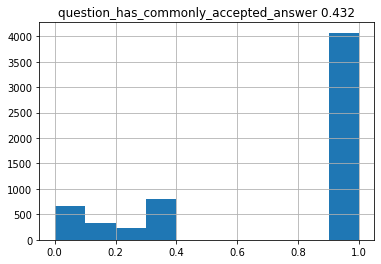

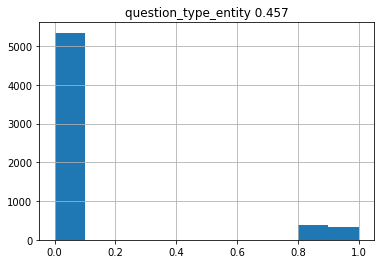

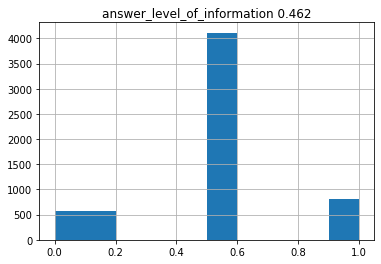

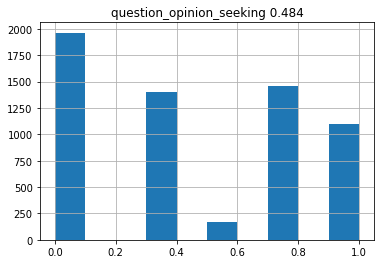

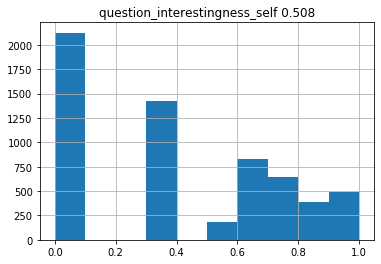

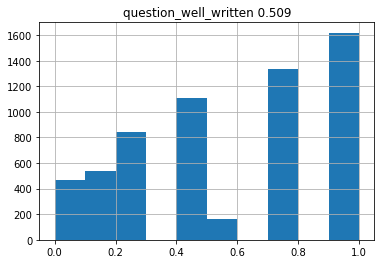

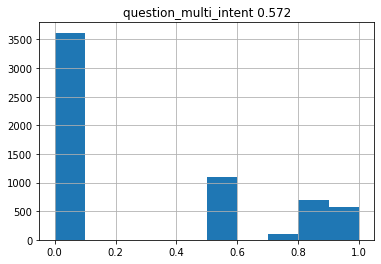

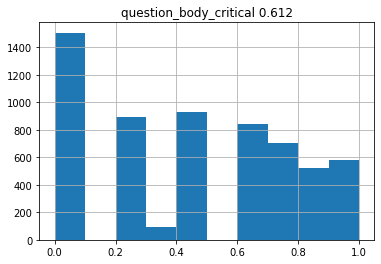

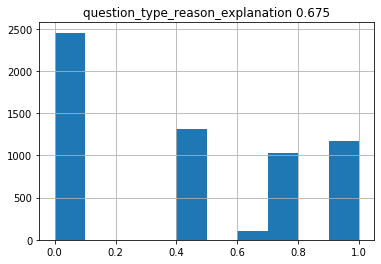

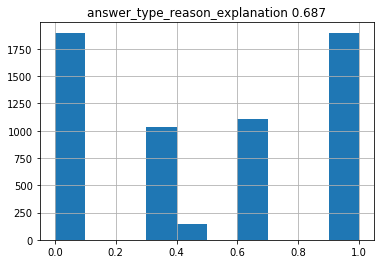

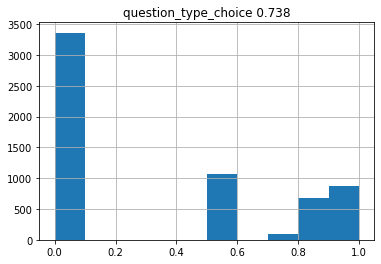

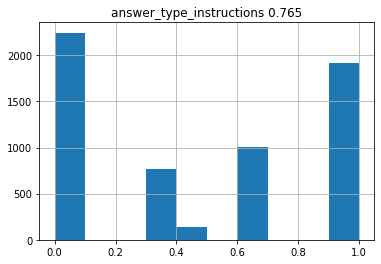

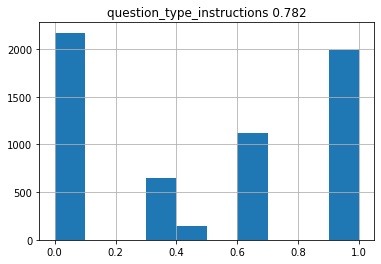

In [25]:
for col in [target for target in sorted_targets if target not in worst_five_targets]:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')